<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Loading Dataframe

In [2]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Prediction

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

In [3]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [4]:
print(len(TO_USE))
df[TO_USE].head()

19


,koi_insol,koi_fpflag_ss,koi_depth,koi_slogg,koi_prad,ra,koi_steff,koi_impact,koi_fpflag_nt,koi_srad,koi_period,koi_duration,koi_time0bk,koi_teq,koi_model_snr,koi_fpflag_ec,dec,koi_fpflag_co,koi_kepmag
0,93.59,0,615.8,4.467,2.26,291.93423,5455.0,0.146,0,0.927,9.488036,2.95750,170.538750,793.0,35.8,0,48.141651,0,15.347
1,9.11,0,874.8,4.467,2.83,291.93423,5455.0,0.586,0,0.927,54.418383,4.50700,162.513840,443.0,25.8,0,48.141651,0,15.347
2,39.30,1,10829.0,4.544,14.60,297.00482,5853.0,0.969,0,0.868,19.899140,1.78220,175.850252,638.0,76.3,0,48.134129,0,15.436
3,891.96,1,8079.2,4.564,33.46,285.53461,5805.0,1.276,0,0.791,1.736952,2.40641,170.307565,1395.0,505.6,0,48.285210,0,15.597
4,926.16,0,603.3,4.438,2.75,288.75488,6031.0,0.701,0,1.046,2.525592,1.65450,171.595550,1406.0,40.9,0,48.226200,0,15.509


# Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the `disposition value` is *not* `CANDIDATE`. This is because `CANDIDATE` is the **default value** for all obects of interest picked up by Kepler. The labels `CONFIRMED` and `FALSE POSITIVE` serve as our positive and negative labels

#### Difference between disposition and pdisposition?

We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While `pdisposition` gives us the **most probable labels based on the physical explanation given by the readings**, `disposition` values are based on **the NASA Exoplanet Archive Data**.  

In [5]:
np.unique(df["koi_disposition"].values)

array(['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [6]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Obtaining X and y

We can encode the categorical labels to 1 and 0 for easier comparison
```
CONFIRMED - 1
FALSE POSITIVE - 0
```

In [7]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [8]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4647
CONFIRMED         2292
Name: koi_disposition, dtype: int64

# PCA Visualisation

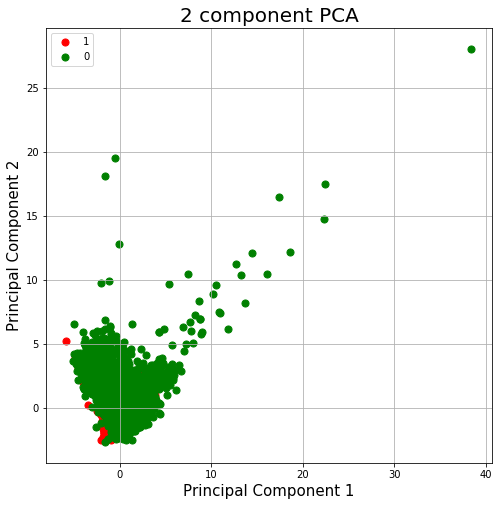

In [9]:
x = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["TARGET"] = y
finalDf = principalDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
# print(finalDf)

colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

* We observe that the two classes are **not** linearly separable, hence a simple Logistic Regression classifier will not do well.
* Furthermore, an SVM model might not work either since there is quite a bit of overlap between two classes. Additionally, there is no plane that can linearly separate the classes once projected to a different dimension.
* Most important, we see there is a **class imbalance** present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as 
* Decision Trees
* Random Forests
* Gradient Boosting Classifier
* XGBoost
* AdaBoost

# Splitting into Train and Test sets

* Scale the values to make the models less computationally expensive and convert all the values to the same range
* Split into train and test sets

In [10]:
X = StandardScaler().fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 19), (2290, 19), (4649,), (2290,))

# Defining Evaluation Metric 

Since the dataset is imbalanced, we cannot use accuracy, hence we opt for either of the following -
* Confusion Matrix
* F1 Score
* Cohen Kappa Score
* Balanced Accuracy Score

In [13]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

# Decision Tree

In [14]:
# baseline model
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [15]:
performance(y_test, pred)

F1 Score: 0.9536784741144414
Kappa Score: 0.9318278131315076
Accuracy Score: 0.9652474679648593
Confusion Matrix:
[[1522   32]
 [  36  700]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1554
           1       0.96      0.95      0.95       736

    accuracy                           0.97      2290
   macro avg       0.97      0.97      0.97      2290
weighted avg       0.97      0.97      0.97      2290



## Checking Cross Validation Score

In [16]:
K=10

In [17]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

Average F1 score over Folds: 0.9635238973800344


In [18]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

Average F1 score over Folds: 0.962703637566779


In [19]:
K=10

In [20]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

Average F1 score over Folds: 0.9635238973800344


In [21]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

Average F1 score over Folds: 0.962703637566779


In [22]:
## Visualising Decision Tree

In [23]:
#tree.plot_tree(classifier, filled=True)
dot_tree = tree.export_graphviz(
    classifier,
    feature_names=subset_df[TO_USE].columns,  
    class_names=np.unique(subset_df["koi_disposition"].values),  
    filled=True, rounded=True,  
    special_characters=True
)
graph = graphviz.Source(dot_tree) 
graph.render("Decision_Tree_Viz")
#graph

'Decision_Tree_Viz.pdf'

## Hyperparameter Tuning for Decision Tree

In [24]:
parameters = {
    #"criterion":["gini", "entropy"],
    "splitter":["best", "random"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    "min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    "min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    "min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    "min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    "class_weight":[None, "balanced"],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    "ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [25]:
"""classifier = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

'classifier = GridSearchCV(\n    DecisionTreeClassifier(),\n    param_grid=parameters,\n    scoring=scores,\n    refit=False,\n    verbose=1,\n    n_jobs=-1\n)\n\nclassifier.fit(X_train, y_train)'

# Random Forest

In [26]:
# baseline model
classifier = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [27]:
performance(y_test, pred)

F1 Score: 0.9736111111111111
Kappa Score: 0.9615179152633515
Accuracy Score: 0.9752575751217056
Confusion Matrix:
[[1551    3]
 [  35  701]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1554
           1       1.00      0.95      0.97       736

    accuracy                           0.98      2290
   macro avg       0.99      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Checking Cross Validation Score

In [28]:
K=10

In [29]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

Average F1 score over Folds: 0.9803871424175034


In [ ]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

## Hyperparameter Tuning for Random  Forest

In [ ]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
"""classifier = GridSearchCV(
    RandomForestClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

# XGBoost

In [ ]:
# baseline model
classifier = XGBClassifier(random_state=0, n_jobs=-1)
classifier.fit(X_train, y_train)

In [ ]:
pred = classifier.predict(X_test)
performance(y_test, pred)

## Checking Cross Validation Score

In [ ]:
K=10

In [ ]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

In [ ]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

## Hyperparameter Tuning for XGBoost

In [ ]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
"""classifier = GridSearchCV(
    XGBClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

# Gradient Boosting Classifier

In [ ]:
# baseline model
classifier = GradientBoostingClassifier(random_state=0)
classifier.fit(X_train, y_train)

In [ ]:
pred = classifier.predict(X_test)
performance(y_test, pred)

## Checking Cross Validation Score

In [ ]:
K=10

In [ ]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

In [ ]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

## Hyperparameter Tuning for GBC

In [ ]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
"""classifier = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

# Adaboost

In [ ]:
# baseline model
classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_train, y_train)

In [ ]:
pred = classifier.predict(X_test)
performance(y_test, pred)

## Checking Cross Validation Score

In [ ]:
K=10

In [ ]:
cv = KFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

In [ ]:
cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"Average F1 score over Folds: {scores.mean()}")

## Hyperparameter Tuning for AdaBoost

In [ ]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
"""classifier = GridSearchCV(
    AdaBoostClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""